# Coursera Segmenting and Clustering Neighborhoods in Toronto

### Section 1: 
In this section, I will be gathering all the Toronto postal codes from the web and grouping neighborhoods by those postal codes.

In [1]:
# Import / install required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import requests
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

Below, I opened the provided URL and scraped all required data into rows of strings.  From there, I cleaned up the strings by removing wierd spaces and puncuations, and the gathered them all into a DataFrame.  Once in a DataFrame, I concantenated and grouped the neighborhoods under their respective postal code.

In [2]:
# Open target URL.
html = urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

# Create BeautifulSoup web-parser.
soup = BeautifulSoup(html, 'html.parser')

# Find attribute table, scrap data and clean text.
table = soup.find('table', {'class': 'wikitable sortable'})
rows = table.find_all('tr')
list_rows = []

for row in rows:
    cells = row.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '',str_cells))
    if len(clean2) > 2:
        list_rows.append(clean2.strip('[]')[:-1])
    else:
        continue
 
# Create dataframe of all collected web data.
df = pd.DataFrame(list_rows)
postalcode_df = df[0].str.split(',', expand=True)
postalcode_df.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Remove rows were "Borough" = "Not Assinged" then group neighborhoods by Borough.
for column in postalcode_df.columns.values:
    postalcode_df[column] = postalcode_df[column].str.strip()

postalcode_df = postalcode_df[postalcode_df.Borough != 'Not assigned'].reset_index(drop=True)
postalcode_df.loc[(postalcode_df.Neighborhood == 'Not assigned'), 'Neighborhood'] = postalcode_df[postalcode_df.Neighborhood == 'Not assigned'].Borough.item()
postalcode_df = postalcode_df.groupby(['PostalCode','Borough']).Neighborhood.unique().apply(lambda x: ', '.join(x)).reset_index()
postalcode_df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


This seems pretty close to the example in the course.

In [3]:
# Check DataFrame shape.
postalcode_df.shape

(103, 3)

### Section 2: 
In this section, added the geographic coordinates to the previously produced DataFrame.

I used the csv link provided to avoid difficulty with the Geocoder package.

In [4]:
# Read in coordinate data for gathered postal codes.
df=pd.read_csv('https://cocl.us/Geospatial_data')
df.columns = ['PostalCode', 'Latitude', 'Longitude']
df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Then I joined the two on their PostalCode columns.

In [5]:
# Combine coordinates and Borough / Neighborhood DataFrames.
coordinate_df = postalcode_df.join(df.set_index('PostalCode'), on='PostalCode')
coordinate_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [6]:
# Check DataFrame shape.
coordinate_df.shape

(103, 5)

### Section 3: 
In this section, I used the combined DataFrame from the previous section to cluster and plot the select neighborhoods.

For simplicity, I decided to work with only boroughs that contain the word Toronto.  All others are removed.

In [7]:
# Retrieve all Borough names.
coordinate_df.Borough.unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke', "Queen's Park"], dtype=object)

In [8]:
# Remove all boroughs withough "Toronto" in the name.
for borough in coordinate_df.Borough.unique():
    if "Toronto" not in borough:
        coordinate_df = coordinate_df[coordinate_df.Borough != borough]
        
coordinate_df.Borough.unique()

array(['East Toronto', 'Central Toronto', 'Downtown Toronto',
       'West Toronto'], dtype=object)

In [9]:
coordinate_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Next, I used my Foursquare API credentials to gather venue data for the neighborhoods.  Credentials are confidential and were removed.

In [11]:
# Store Foursquare credentials and parameters.
CLIENT_ID = '' # Confidential.
CLIENT_SECRET = '' # Confidential.
VERSION = '20180605' 
LIMIT = 100
radius = 500

In [12]:
# Retrieve venue data from Foursquare.
venues_list=[]
for name, lat, lng in zip(coordinate_df['Neighborhood'], 
                          coordinate_df['Latitude'], 
                          coordinate_df['Longitude']):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

toronto_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
toronto_venues.columns = ['Neighborhood', 
                         'Neighborhood Latitude', 
                         'Neighborhood Longitude', 
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Next, I sought to explore the venus data gathered from Foursquare.

In [13]:
# Remove "Neighborhood" from list of venues
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",99,99,99,99,99,99
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16


In [14]:
# Print number of unique catagories.
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


In [15]:
# Print top 120 most common venue types.
toronto_venues['Venue Category'].value_counts().head(10)

Coffee Shop            160
Café                    91
Restaurant              53
Italian Restaurant      44
Bakery                  39
Bar                     39
Park                    35
Hotel                   34
Japanese Restaurant     30
Pizza Place             27
Name: Venue Category, dtype: int64

Lots of coffee shops, cafes and other small eateries. 

Creating a table of venues per neighborhood is critical for clustering.

In [16]:
# Create table of venues per neighborhood.
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Check DataFrame shape.
toronto_onehot.shape

(1709, 230)

Then aggregate the table to the mean frequency of occurrence for each category per neighborhood.

In [18]:
# Aggregate neighborhood venues by means.
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.020202,0.0,...,0.0,0.0,0.0,0.020202,0.0,0.0,0.010101,0.0,0.010101,0.0
1,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.0,0.000000,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


In [19]:
# Check DataFrame shape.
toronto_grouped.shape

(39, 230)

In [20]:
# Create table of most common venues per neighborhood.
# Define function.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Cosmetics Shop,Burger Joint,Breakfast Spot,Bakery,Restaurant,Asian Restaurant,Thai Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Bakery,Steakhouse,Seafood Restaurant,Cheese Shop,Café,Gourmet Shop
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Nightclub,Stadium,Bar,Bakery,Restaurant,Intersection,Italian Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Park,Auto Workshop,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Spa
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Airport,Airport Food Court,Airport Gate,Bar,Boutique,Harbor / Marina,Boat or Ferry


Just from this sample, I can see some notable differences in the neighborhoods.  For example, Adelaide, King, Richmond and Berczy Park appear to be predominantly coffee shops, bars and small eateries.  CN Tower, Bathurst Quay area has a more active airport, marina and car rental location.

Time for clustering analysis.  To determine the appropriate k-value, I will try both Elbow and Silhuette tests. <br>
First, Elbow:

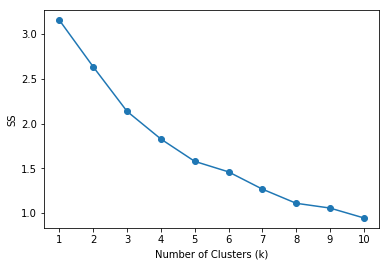

In [21]:
# Conduct Elbow Sum-of-Squares test on clustering DataFrame.
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

k_range = range(1,11)
sum_of_squares = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(toronto_grouped_clustering)
    sum_of_squares.append(KM.inertia_)
    
plt.plot(k_range, sum_of_squares, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

The bend seems to be most prominent at k = 5. <br>
Now let's try a Silhuette test.

In [24]:
# Conduct silhouette test on clustering DataFrame.
from sklearn.metrics import silhouette_samples, silhouette_score

best=0

for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(toronto_grouped_clustering)
    silhouette_avg = silhouette_score(toronto_grouped_clustering, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.43602895492511057
For n_clusters = 3 The average silhouette_score is : 0.4373752322777888
For n_clusters = 4 The average silhouette_score is : 0.44380594732253187
For n_clusters = 5 The average silhouette_score is : 0.4362041533927963
For n_clusters = 6 The average silhouette_score is : 0.439881476400317
For n_clusters = 7 The average silhouette_score is : 0.25346374573001557
For n_clusters = 8 The average silhouette_score is : 0.15880681981417327
For n_clusters = 9 The average silhouette_score is : 0.22206854036688325
For n_clusters = 10 The average silhouette_score is : 0.1963826276141048
Optimal KMeans n_clusters parameter: 4


Silhuette test indicates k = 4 as the best value.  I'll try 4.

In [27]:
# run k-means clustering.
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# Print count of neighborhoods per cluster.
pd.Series(kmeans.labels_).value_counts()

3    33
1     4
2     1
0     1
dtype: int64

Not a spectacular result.  I'll update the *toronto_merged* table and plot the clusters on a Folium map.

In [28]:
# add clustering labels.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = coordinate_df.drop('PostalCode', axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood.
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,The Beaches,43.676357,-79.293031,1,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
41,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,3,Greek Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Furniture / Home Store,Restaurant,Ice Cream Shop,Dessert Shop,Caribbean Restaurant,Bakery
42,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,3,Sandwich Place,Park,Pub,Food & Drink Shop,Burger Joint,Burrito Place,Italian Restaurant,Liquor Store,Ice Cream Shop,Fast Food Restaurant
43,East Toronto,Studio District,43.659526,-79.340923,3,Café,Coffee Shop,American Restaurant,Italian Restaurant,Brewery,Bakery,Gastropub,Yoga Studio,Diner,Bookstore
44,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Park,Construction & Landscaping,Swim School,Bus Line,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [29]:
# Import Nominatim.
from geopy.geocoders import Nominatim

# Retrieve coordinates for Toronto.
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [87]:
# Create mpa visual with clustered neighborhoods.
# Create folium map.
zoom = 12
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=zoom, min_zoom=zoom, max_zoom=zoom)

# Set color scheme for the clusters.
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow((np.linspace(0, 1, len(ys))))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map.
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The main cluster (3, green) seems to occupy the bulk of downtown Toronto while the others seem to be on the outer edges of the specified neighborhoods.  Let's see some details:

In [33]:
df_cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,Garden,Music Venue,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


Cluster 0 (red) is primarily residential area of northern Toronto. Being such, there is not a dense commerical presence as inidcated by the frequency of gardens, music venues and yog studios.

In [34]:
df_cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,The Beaches,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
48,"Moore Park, Summerhill East",Park,Playground,Tennis Court,Trail,Doner Restaurant,Dog Run,Donut Shop,Discount Store,Cuban Restaurant,Diner
50,Rosedale,Park,Playground,Trail,Cupcake Shop,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
64,"Forest Hill North, Forest Hill West",Jewelry Store,Trail,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


Custer 1 (blue) seems to be primarily outdoor activity venues; trails, parks, playgrounds, tennis courts.

In [35]:
df_cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,Park,Construction & Landscaping,Swim School,Bus Line,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


Cluster 2 (teal) has a few parks and businesses.  Seems like a developing commerical area.

In [36]:
df_cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
df_cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Furniture / Home Store,Restaurant,Ice Cream Shop,Dessert Shop,Caribbean Restaurant,Bakery
42,"The Beaches West, India Bazaar",Sandwich Place,Park,Pub,Food & Drink Shop,Burger Joint,Burrito Place,Italian Restaurant,Liquor Store,Ice Cream Shop,Fast Food Restaurant
43,Studio District,Café,Coffee Shop,American Restaurant,Italian Restaurant,Brewery,Bakery,Gastropub,Yoga Studio,Diner,Bookstore
45,Davisville North,Hotel,Park,Breakfast Spot,Gym,Sandwich Place,Food & Drink Shop,Department Store,Yoga Studio,Donut Shop,Doner Restaurant
46,North Toronto West,Clothing Store,Coffee Shop,Yoga Studio,Salon / Barbershop,Restaurant,Café,Chinese Restaurant,Pet Store,Cosmetics Shop,Sporting Goods Shop
47,Davisville,Sandwich Place,Pizza Place,Dessert Shop,Sushi Restaurant,Gym,Café,Italian Restaurant,Coffee Shop,Park,Brewery
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Pub,Supermarket,Sports Bar,Sushi Restaurant,Vietnamese Restaurant,Light Rail Station,Liquor Store,American Restaurant,Pizza Place
51,"Cabbagetown, St. James Town",Coffee Shop,Café,Convenience Store,Italian Restaurant,Park,Bakery,Pizza Place,Restaurant,Pub,Yoga Studio
52,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Gym
53,Harbourfront,Coffee Shop,Café,Park,Pub,Bakery,Mexican Restaurant,Restaurant,Breakfast Spot,Performing Arts Venue,Chocolate Shop


Cluster 3 is easily the largest and seems to account for most of the downtown Toronto area.  Lots of restaraunts of all varieties, shops, bars, a few parks and the airport.

In [88]:
for i, column in enumerate (df_cluster_3.columns[1:]):
    if i < 3:
        print(column + '(%):')
        print(round(df_cluster_3[column].value_counts()/len(df_cluster_3[column])*100,2))
        print('')

1st Most Common Venue(%):
Coffee Shop           48.48
Café                   9.09
Sandwich Place         9.09
Gift Shop              3.03
Clothing Store         3.03
Grocery Store          3.03
Breakfast Spot         3.03
Airport Service        3.03
Bar                    3.03
Mexican Restaurant     3.03
Light Rail Station     3.03
Pharmacy               3.03
Hotel                  3.03
Greek Restaurant       3.03
Name: 1st Most Common Venue, dtype: float64

2nd Most Common Venue(%):
Café                     36.36
Park                     12.12
Coffee Shop               9.09
Pizza Place               6.06
Aquarium                  3.03
Bookstore                 3.03
Japanese Restaurant       3.03
Clothing Store            3.03
Ice Cream Shop            3.03
Breakfast Spot            3.03
Bakery                    3.03
Vietnamese Restaurant     3.03
Airport Lounge            3.03
Pub                       3.03
Cocktail Bar              3.03
Asian Restaurant          3.03
Name: 2nd Most 

The most common venues here are coffee shops and small eateries.